<a href="https://colab.research.google.com/github/zahidcv/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My plan:



---


1. Colected Dataset from 3 sources.

2.   managed to gather total of around **45 pairs** of clean and noisy image
3.   created patch of size `64 x 64`
4.   defined 2 functions `gan-fit`(only works with gan loss) and `no-gan-fit`    only works with mse loss)

5. defined 2 functions `gan-fit`(only works with gan loss) and `no-gan-fit` (only works with mse loss)

Findings:


---


1. `No GAN` function(only mse loss) seems to work and achieved 27 PSNR


problem:

---

1. `Gan` function seem to learn nothing. The Discriminator loss become 0 and Generator loss gets sky-rocketed
2. Denoised Image is a completely black image


TODO:

---

1. ~batchnorm in enc, layer norm in dcd~
2. ~residual connection~
3. ~Our classifier model~
4. ~Remove the last skip connection to see if the noise reduces~



# Importing & setting up device

In [1]:
import os, shutil
from os.path import join, isdir
from os import mkdir, makedirs

import cv2
import sys
import csv
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter
# from skimage.measure import compare_ssim
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from torch.utils.data import random_split
import pandas as pd
try:
  from patchify import patchify, unpatchify
except:
  !pip install patchify
  from patchify import patchify, unpatchify
try:
  from torchsummary import summary
except:
  !pip install torchsummary
  from torchsummary import summary



In [2]:
# # Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

# #setting up Device for device agnostic code

if torch.cuda.is_available():
    DEVICE = "cuda"
# elif torch.mps.backened.is_available():
#     DEVICE = "mps"
else:
    DEVICE = "cpu"

print(DEVICE)


if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    if not isdir("/content/Organised Dataset"):
        print("Downloading dataset")
        # !pip install -U --no-cache-dir gdown --pre
        # !gdown 1nmld3mwrm1Sxij0Bv9idhcQBM27HhbPn
        !unzip '/content/drive/MyDrive/Research/Datasets/OCT datasets/Organised Dataset.zip'
    !wget https://raw.githubusercontent.com/zahidcv/OCT-Image-Denoising/main/utils.py

import utils

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Organised Dataset/Clean/8330 PKU/._8330 PKU.tif  
  inflating: Organised Dataset/Clean/7003 PKU/7003 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/7003 PKU/._7003 PKU.tif  
  inflating: Organised Dataset/Clean/5614 PKU/5614 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/5614 PKU/._5614 PKU.tif  
  inflating: Organised Dataset/Clean/8318 PKU/8318 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/8318 PKU/._8318 PKU.tif  
  inflating: Organised Dataset/Clean/6447 PKU/6447 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/6447 PKU/._6447 PKU.tif  
  inflating: Organised Dataset/Clean/5628 PKU/5628 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/5628 PKU/._5628 PKU.tif  
  inflating: Organised Dataset/Clean/4907 PKU/4907 PKU.tif  
  inflating: __MACOSX/Organised Dataset/Clean/4907 PKU/._4907 PKU.tif  
  inflating: Organised Dataset/Clean/4913 PKU/4913 PKU.tif  
  inflating: __MAC

In [3]:
!wget https://raw.githubusercontent.com/zahidcv/OCT-Image-Denoising/main/utils.py

--2023-10-28 10:32:35--  https://raw.githubusercontent.com/zahidcv/OCT-Image-Denoising/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8484 (8.3K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   8.29K  --.-KB/s    in 0s      

2023-10-28 10:32:36 (100 MB/s) - ‘utils.py.1’ saved [8484/8484]



In [4]:


    # if not isdir("/content/Test_Set"):
    #     print("Downloading Test dataset")
    #     !pip install -U --no-cache-dir gdown --pre
    #     !gdown 1igwzf0HvwdfHE6J_ay0dkHZDPiOdakI8
        # !unzip '/content/Test_Set.zip'
    # if not isdir("/content/Test_Set2"):
    #     print("Downloading Test dataset")
    #     !pip install -U --no-cache-dir gdown --pre
    #     !gdown 1ieBkYM-W-qHwoVVYGOHPyZKGH6lZiVGI
    #     !unzip '/content/Test_Set2.zip'

    # if not isdir("/content/Models"):
    #     print("Downloading Model")
    #     !pip install -U --no-cache-dir gdown --pre
    #     !gdown 1Ggd_kuMe1JDx7idw8co24r03V_aWUTf-


    # run_path = '/content/runs/OCT Denoise'
    # from distutils.dir_util import copy_tree
    # copy_tree("/content/drive/MyDrive/Research/runs", run_path)
    # https://drive.google.com/file/d/1Ggd_kuMe1JDx7idw8co24r03V_aWUTf-/view?usp=share_link
  # https://drive.google.com/file/d/1nmld3mwrm1Sxij0Bv9idhcQBM27HhbPn/view?usp=sharing

  #Test Seet 1
  # https://drive.google.com/file/d/1igwzf0HvwdfHE6J_ay0dkHZDPiOdakI8/view?usp=sharing
  #Test set 2
  #https://drive.google.com/file/d/1ieBkYM-W-qHwoVVYGOHPyZKGH6lZiVGI/view?usp=sharing
  # !unzip '/content/Patch OCT Dataset.zip'
    # https://drive.google.com/drive/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW?usp=sharing
    # https://drive.google.com/drive/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW?usp=sharing
    # https://drive.google.com/drive/u/1/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW
    #   from google.colab import drive
#   drive.mount('/content/drive')

#   # Defining Data Path
#   Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'

In [5]:
!nvidia-smi

Sat Oct 28 10:32:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading dataset

## Train Data paths

In [6]:
if COLAB:
    patch_data_dir = '/content/Organised Dataset'
elif DEVICE == 'mps':
    pass
else:
    patch_data_dir = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\Patch Train OCT Dataset"

clean_data_dir = join(patch_data_dir, 'Clean')
noisy_data_dir = join(patch_data_dir, 'Noisy')
TRAIN_IMAGE_PATHS = []
TEST_IMAGE_PATHS = []

for folder in sorted(os.listdir(clean_data_dir)):

    if folder[0] == '.':
        continue

    clean_folder_path = join(clean_data_dir, folder)
    noisy_folder_path = join(noisy_data_dir, folder)
    # print(current_folder_path)
    for img in sorted(os.listdir(clean_folder_path)):
        if img[0] == '.':
            continue
        # print(img)

        clean_img_path = join(clean_folder_path, img)
        noisy_img_path = join(noisy_folder_path, img)

        if 'PKU' in folder:
            TRAIN_IMAGE_PATHS.append([noisy_img_path, clean_img_path])
        else:
            TEST_IMAGE_PATHS.append([noisy_img_path, clean_img_path])
        # print(clean_img_path, noisy_img_path)


In [7]:
print(len(TRAIN_IMAGE_PATHS))
print(len(TEST_IMAGE_PATHS))

1548
44


## Test Data Paths

In [8]:
# if COLAB:
#     test_data_dir = '/content/Test_Set'
# elif DEVICE == 'mps':
#     pass
# else:
#     test_data_dir = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\Patch Test OCT Dataset"


# clean_data_dir = join(test_data_dir, 'Clean')
# noisy_data_dir = join(test_data_dir, 'Noisy')
# TEST_IMAGE_PATHS = []

# for folder in sorted(os.listdir(clean_data_dir)):

#     if folder[0] == '.':
#         continue

#     clean_folder_path = join(clean_data_dir, folder)
#     noisy_folder_path = join(noisy_data_dir, folder)
#     # print(current_folder_path)
#     for img in sorted(os.listdir(clean_folder_path)):
#         if img[0] == '.':
#             continue
#         # print(img)

#         clean_img_path = join(clean_folder_path, img)
#         noisy_img_path = join(noisy_folder_path, img)

#         TEST_IMAGE_PATHS.append([noisy_img_path, clean_img_path])
#         # print(clean_img_path, noisy_img_path)





# HyperParameters 1

In [9]:
BATCH_SIZE = 8
IMG_SIZE = 256
TEST_IMG_SIZE = (448,832)
IMG_CHANNELS = 1

PATCH_SIZE = 256
STEP_SIZE = 64

#  Datasets and Dataloaders

## Creating Dataset

### Custom Dataset Class

In [10]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    noisy_img = Image.open(self.paths[index][0])
    clean_img = Image.open(self.paths[index][1])
    # clean_img = transforms.functional.adjust_sharpness(clean_img,sharpness_factor=10)

    if self.transform:
      return self.transform(noisy_img), self.transform(clean_img)

    return noisy_img, clean_img

  def __len__(self):
    return len(self.paths)


"""
1. sharpenning the image before doesn't work.
"""


"\n1. sharpenning the image before doesn't work.\n"

### Transformations

In [11]:
# defining Transforms Needed to be done on the Images
trans = transforms.Compose([

    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

# defining Transforms Needed to be done on the Images
test_trans = transforms.Compose([

    transforms.Resize(TEST_IMG_SIZE),

    transforms.ToTensor(),

    # transforms.Normalize(mean=[0.5], std=[0.5])
])

### Dataset Instance

In [12]:
# Dataset
# dataset = CustomDataset(TRAIN_IMAGE_PATHS, transform = trans)

# train_size =  int(0.8 * len(dataset))  # 80% for training
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset = CustomDataset(TRAIN_IMAGE_PATHS, transform = trans)
test_dataset = CustomDataset(TEST_IMAGE_PATHS, transform = test_trans)

print(len(train_dataset))

print(len(test_dataset))

1548
44


(-0.5, 255.5, 255.5, -0.5)

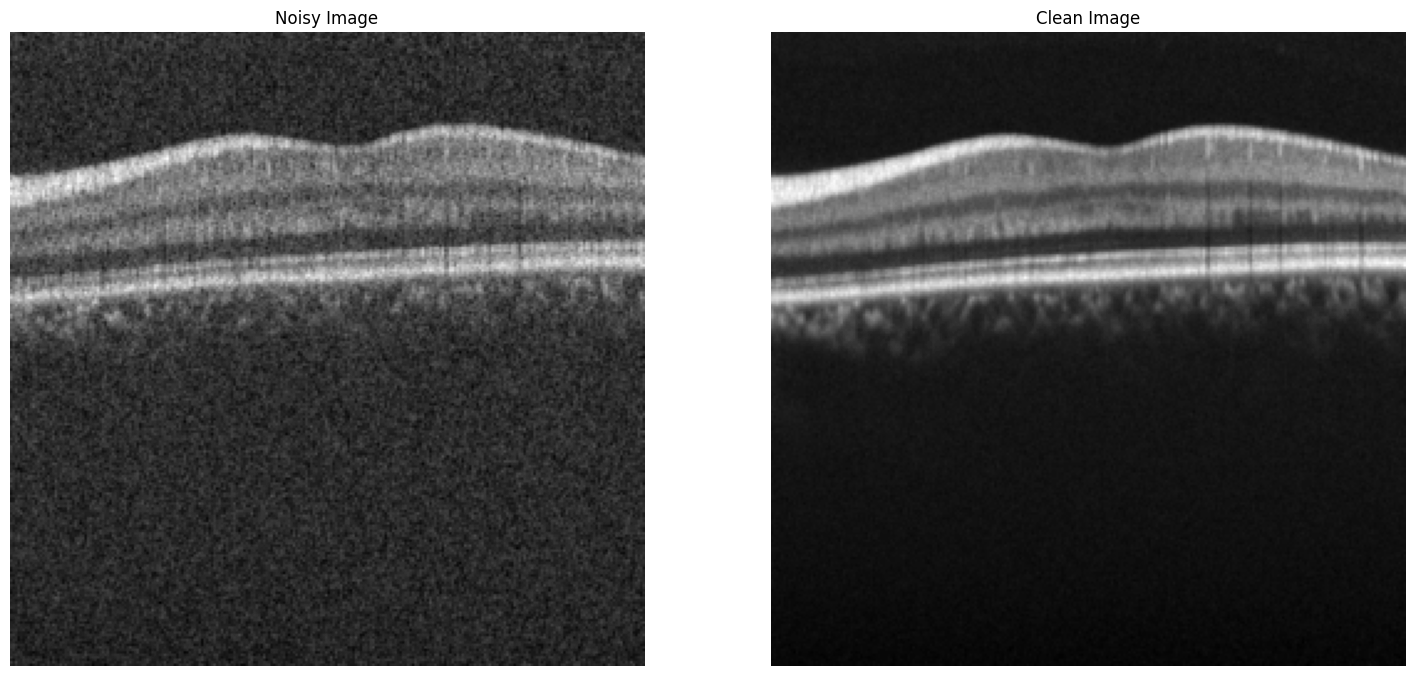

In [13]:
n,c = train_dataset[500][0].squeeze(), train_dataset[500][1].squeeze()
plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(n.squeeze(), cmap = 'gray')
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(c.squeeze(), cmap = 'gray')
plt.title('Clean Image')
plt.axis("off")



In [14]:
n.shape

torch.Size([256, 256])

(-0.5, 255.5, 255.5, -0.5)

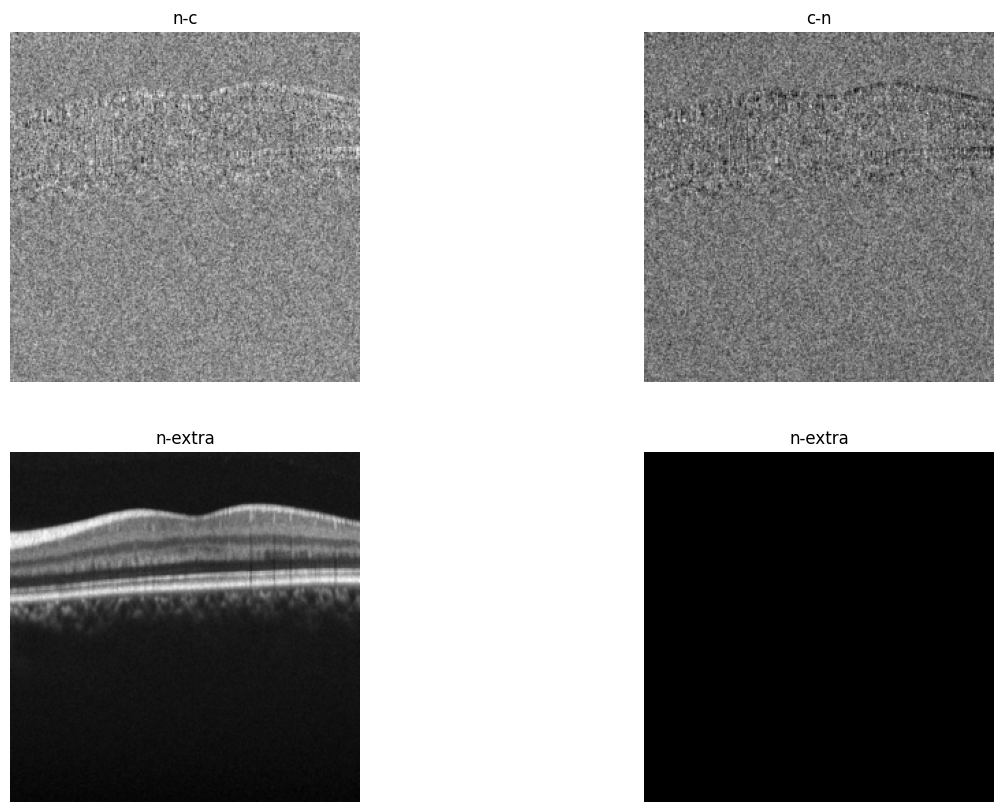

In [15]:
extra = n-c

noise_minus_extra = n-extra

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.imshow(n-c, cmap = 'gray')
plt.title('n-c')
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(c-n, cmap = 'gray')
plt.title('c-n')
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(noise_minus_extra, cmap = 'gray')
plt.title('n-extra')
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(noise_minus_extra - c , cmap = 'gray')
plt.title('n-extra')
plt.axis("off")

(-0.5, 831.5, 447.5, -0.5)

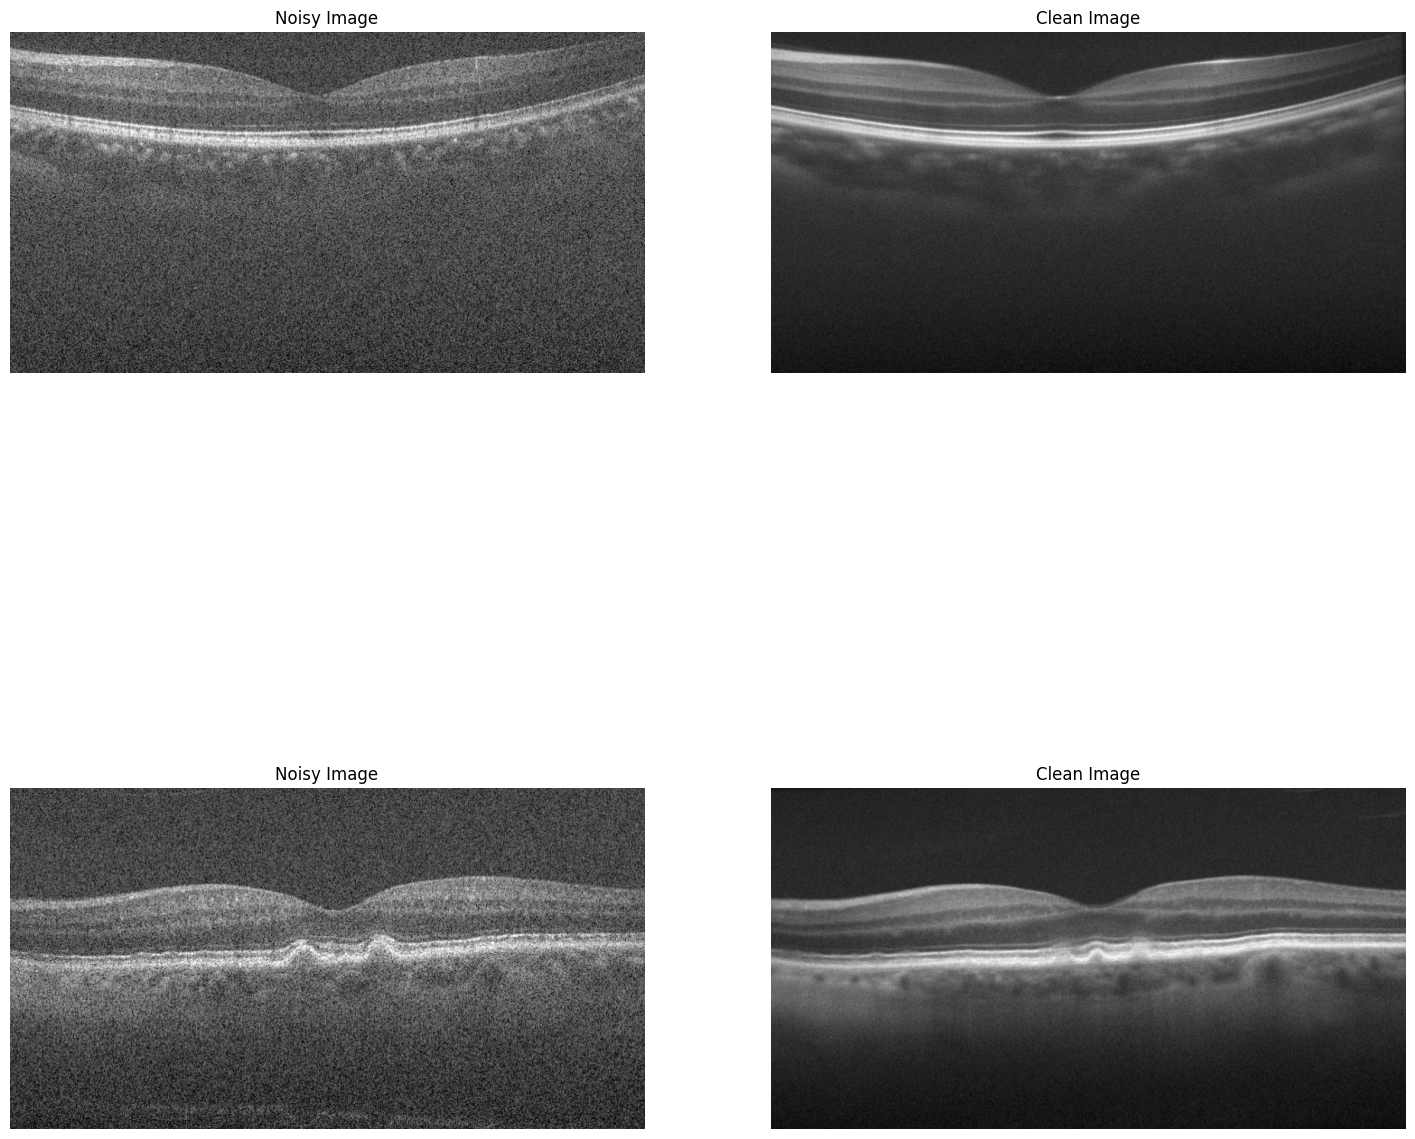

In [16]:
n,c = test_dataset[1][0], test_dataset[1][1]
n2, c2 = test_dataset[5][0], test_dataset[5][1]
plt.figure(figsize = (18,18))

plt.subplot(2,2,1)
plt.imshow(n.squeeze(), cmap = 'gray')
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(c.squeeze(), cmap = 'gray')
plt.title('Clean Image')
plt.axis("off")


plt.subplot(2,2,3)
plt.imshow(n2.squeeze(), cmap = 'gray')
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(c2.squeeze(), cmap = 'gray')
plt.title('Clean Image')
plt.axis("off")



## Data Loader

In [17]:
train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True,)
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True,)


# Traditional Models

In [18]:
# bilat(n.squeeze(),c.squeeze())

In [19]:
# from skimage.metrics import structural_similarity
# (sim, diff) = structural_similarity(n.squeeze().numpy(), n.squeeze().numpy(), full = True)
# print(sim)
# plt.imshow(diff, 'gray')

# Model Creation

## Deep Generator Model

In [20]:
# class Deep_Generator(nn.Module):

#   def __init__(self):
#     super().__init__()

#     self.enc_block1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2),
#             )
#     self.enc_block3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block6 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2)
#         )

#     # decoder layers
#     self.dcd_block1 = nn.Sequential(
#         nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(256),
#         nn.LeakyReLU(0.2),
#     )
#     self.dcd_block2 = nn.Sequential(
#         nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(128),
#         nn.LeakyReLU(0.2),
#     )
#     self.dcd_block3 = nn.Sequential(
#         nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(64),
#         nn.LeakyReLU(0.2),
#     )

#     self.dcd_block4 = nn.Sequential(
#         nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(32),
#         nn.LeakyReLU(0.2),
#     )

#     self.dcd_block5 = nn.Sequential(
#         nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(16),
#         nn.LeakyReLU(0.2),
#     )

#     self.output_block = nn.Sequential(
#         nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
#         nn.Sigmoid()
#     )

#     for m in self.modules():
#       if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         # nn.init.normal_(m.weight, mean=0, std=0.01)
#         # nn.init.zeros_(m.weight)
#         # nn.init.zeros_(m.bias)

#         # Xavier
#         # nn.init.xavier_normal_(m.weight)

#         #He Init
#         nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#     # self.apply(self._init_weights)

#   # def _init_weights(self, module):
#   #   if isinstance(module, nn.Linear):
#   #     module.weight.data.normal_(mean=0.0, std=1.0)
#   #     if module.bias is not None:
#   #         module.bias.data.zero_()


#   # initialize weights from a normal distribution with mean 0 and std 0.01




#   def forward(self, x):

#     out_enc1 = self.enc_block1(x)
#     # print(f"Out enc1 {out_enc1.shape}")

#     out_enc2 = self.enc_block2(out_enc1)
#     # print(f"Out enc2 {out_enc2.shape}")

#     out_enc3 = self.enc_block3(out_enc2)
#     # print(f"Out enc3 {out_enc3.shape}")

#     out_enc4 = self.enc_block4(out_enc3)
#     # print(f"Out enc4 {out_enc4.shape}")

#     out_enc5 = self.enc_block5(out_enc4)
#     # print(f"Out enc5 {out_enc5.shape}")

#     encoded = self.enc_block6(out_enc5)



#     # print(f"Shape of encoded: {encoded.shape}")


#     out_dcd1 = self.dcd_block1(encoded)
#     #skip
#     out_dcd1 +=out_enc5

#     # print(f"Out dcd1 {out_dcd1.shape}")

#     out_dcd2 = self.dcd_block2(out_dcd1)
#     #skip
#     out_dcd2 +=out_enc4
#     # print(f"Out dcd2 {out_dcd2.shape}")

#     out_dcd3 = self.dcd_block3(out_dcd2)
#     #skip
#     out_dcd3 += out_enc3
#     # print(f"Out dcd3 {out_dcd3.shape}")

#     out_dcd4 = self.dcd_block4(out_dcd3)
#     #skip
#     out_dcd4 += out_enc2
#     # print(f"Out dcd4 {out_dcd4.shape}")

#     out_dcd5 = self.dcd_block5(out_dcd4)
#     #skip
#     out_dcd5 += out_enc1
#     # print(f"Out dcd5 {out_dcd5.shape}")


#     decoded = self.output_block(out_dcd5)
#     # print(f"decoded {decoded.shape}")



#     return decoded


# """
# Init from black performs better
# Lighter Model produces clearer result.
# """

In [21]:
# rand_img = torch.rand([32, 1, 64, 64])
# print(f"Random Image shape: {rand_img.shape}")
# # print()
# generator = Deep_Generator()

# result = generator(rand_img)

# generator = Deep_Generator().to(DEVICE)

# x = n.unsqueeze(dim=1)
# about(x)

# result = generator(x.to(DEVICE))
# print(result.shape)
# with torch.inference_mode():
#   plt.imshow(result.squeeze().to('cpu'), cmap='gray')

## Old Working generator

In [22]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.enc_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
        )
    self.enc_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            )
    self.enc_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )
    self.enc_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

    # decoder layers
    self.dcd_block1 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
#         nn.LayerNorm(normalized_shape=(64, 8, 8)),
        nn.LeakyReLU(0.2),
    )

    self.dcd_block2 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
#         nn.LayerNorm(normalized_shape=(32, 16, 16)),
        nn.LeakyReLU(0.2),
    )

    self.dcd_block3 = nn.Sequential(
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
#         nn.LayerNorm(normalized_shape=(16, 32, 32)),
        nn.LeakyReLU(0.2),
    )

    self.output_block = nn.Sequential(
        nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )

#     for m in self.modules():
#       if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         # nn.init.normal_(m.weight, mean=0, std=0.01)
#         # nn.init.zeros_(m.weight)
#         # nn.init.zeros_(m.bias)

#         # Xavier
#         nn.init.xavier_normal_(m.weight)

        #He Init
#         nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
          module.bias.data.zero_()


  def forward(self, x):

    out_enc1 = self.enc_block1(x)
    # print(f"Out enc1 {out_enc1.shape}")

    out_enc2 = self.enc_block2(out_enc1)
    # print(f"Out enc2 {out_enc2.shape}")

    out_enc3 = self.enc_block3(out_enc2)
    # print(f"Out enc3 {out_enc3.shape}")

    encoded = self.enc_block4(out_enc3)
    # print(f"\n\nencoded {encoded.shape}\n\n")

    out_dcd1 = self.dcd_block1(encoded)

    #skip
    out_dcd1 +=out_enc3

    # print(f"Out dcd1 {out_dcd1.shape}")

    out_dcd2 = self.dcd_block2(out_dcd1)
    #skip
    out_dcd2 +=out_enc2
    # print(f"Out dcd2 {out_dcd2.shape}")

    out_dcd3 = self.dcd_block3(out_dcd2)
    #skip
    # out_dcd3 += out_enc1
    # print(f"Out dcd3 {out_dcd3.shape}")

    decoded = self.output_block(out_dcd3)
    # print(f"decoded {decoded.shape}")

    # print(f"Shape of encoded: {encoded.shape}")

    return decoded


"""
Init from black performs better
Lighter Model produces clearer result.
"""

'\nInit from black performs better\nLighter Model produces clearer result.\n'

### Test Generator Model

In [23]:
rand_img = torch.rand([32, 1, IMG_SIZE, IMG_SIZE]).to(DEVICE)
print(f"Random Image shape: {rand_img.shape}")
# print()
gen = Generator().to(DEVICE)

result = gen(rand_img)
print(result.shape)

Random Image shape: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


<class 'torch.Tensor'>
torch.Size([1, 1, 448, 832])
torch.Size([1, 1, 448, 832])


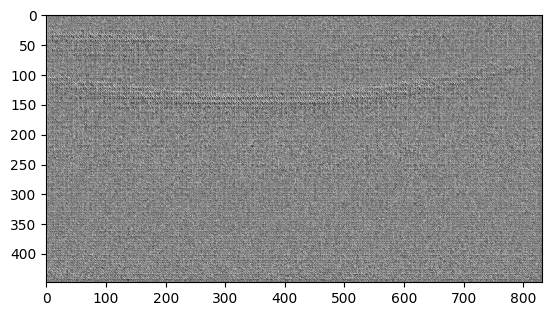

In [24]:


x = n.unsqueeze(dim=1)
utils.about(x)

result = gen(x.to(DEVICE))
print(result.shape)
with torch.inference_mode():
  plt.imshow(result.squeeze().to('cpu'), cmap='gray')

## Discriminitor

In [25]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(

        nn.Conv2d(
            in_channels = input_shape,
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        #
        # nn.Conv2d(
        #     in_channels = 64,
        #     out_channels = 128,
        #     kernel_size = 3,
        #     # padding=1,
        #     # stride=1,

        # ),
        # nn.BatchNorm2d(128),
        # nn.ReLU(),

        # nn.MaxPool2d(
        #     kernel_size = 2,
        #     # stride=2,
        # ),
        #

#         nn.Conv2d(
#             in_channels = 128,
#             out_channels = 256,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,

#         ),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#         #

    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 64*127*127, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = output_shape)

    )

  def forward(self, x):
    x = self.block_1(x)

    # print(x.shape)
    x = self.classifier(x)

    return x

### Test Discriminator

In [26]:
# Test Discriminator
discriminator = Discriminator(1,1).to(DEVICE)
x = torch.rand(size = [BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE]).to(DEVICE)

r = discriminator(x)
print(r.shape)

torch.Size([8, 1])


# VGG Setup

In [27]:
from torchvision import models
vgg = models.vgg19(pretrained=True)
vgg.to(DEVICE)
vgg_features = vgg.features[:37].eval()
vgg_features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
vgg_features = vgg_features.to(DEVICE)
print(vgg_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 100MB/s]


Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Custom Model Setup

In [28]:
# class OCT(nn.Module):
#   def __init__(self, input_shape, output_shape):
#     super().__init__()

#     self.block_1 = nn.Sequential(

# #############################################
#         nn.Conv2d(
#             in_channels = input_shape,
#             out_channels = 64,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),
#         nn.ReLU(),

#         nn.BatchNorm2d(64),


#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),

# ##############################################
#         nn.Conv2d(
#             in_channels = 64,
#             out_channels = 128,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),

#         nn.ReLU(),

#         nn.BatchNorm2d(128),


#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#         #
# #############################################
#         nn.Conv2d(
#             in_channels = 128,
#             out_channels = 256,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),

#         nn.ReLU(),
#         nn.BatchNorm2d(256),
#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#         #
# #############################################
# #         nn.Conv2d(
# #             in_channels = 256,
# #             out_channels = 512,
# #             kernel_size = 3,
# #             # padding=1,
# #             # stride=1,
# #         ),

# #         nn.ReLU(),

# #         nn.MaxPool2d(
# #             kernel_size = 2,
# #             # stride=2,
# #         ),
# #############################################

#     )


#     self.classifier = nn.Sequential(
#         nn.Flatten(),
#         nn.Linear(in_features = 256*14*14, out_features = 1024),
#         nn.ReLU(),
#         nn.Dropout(p=0.4),
# #         nn.Linear(in_features = 4096, out_features = 1024),
# #         nn.ReLU(),
# #         nn.Linear(in_features = 2048, out_features = 1024),
#         nn.Linear(in_features = 1024, out_features = output_shape)

#     )

#   def forward(self, x):
#     x = self.block_1(x)

# #     print(f"Printing X Shape After Conv: {x.shape}")
#     x = self.classifier(x)
# #     print(f"Printing X Shape After OutPut: {x.shape}")

#     return x

#   def features(self, x):
#     output = self.block_1(x)
#     return output

# # 4x73728
# # (4x73728 and 25088x4)

In [29]:
# if COLAB:
#     custom_path = "/content/CNN OCT Classifier 23_Feb__13_44.pth"
# else:
#     custom_path = r"C:\Users\HP\Documents\Zahid\OCT\Models\CNN OCT Classifier 23_Feb__13_44.pth"

# custom_model = OCT(input_shape= 1,
#                 output_shape = 4).to(DEVICE)
# custom_model.load_state_dict(torch.load(custom_path, map_location=DEVICE))



In [30]:
# custom_model.features(torch.randn(32, 1, 64, 64, device=DEVICE)).shape

# Training Testing

## Train Step

### Discriminator Trainer

In [31]:
import torch.nn.functional as F


def train_discriminator(noisy_images, clean_images, optimizer_d):
  generator.eval()
  discriminator.train()
  optimizer_d.zero_grad()

  preds_for_real = discriminator(clean_images)
  targets_for_real = torch.ones(clean_images.size(0), 1, device = DEVICE)

  loss_for_real = bceloss(preds_for_real, targets_for_real)

  fake_clean_images = generator(noisy_images)

  preds_for_fake = discriminator(fake_clean_images)
  targets_for_fake = torch.zeros(fake_clean_images.size(0), 1, device = DEVICE)

  loss_for_fake = bceloss(preds_for_fake, targets_for_fake)


  loss = loss_for_real + loss_for_fake
#   print(f"\033[91m total Loss: {loss}, loss for real -> {loss_for_real}, Loss For Fake -> {loss_for_fake} \033[00m")

  loss.backward()

  optimizer_d.step()

  return loss.item()




### Generator Trainer

In [32]:
def ssim_calculator_new(clean_images, fake_images):
    total_ssim = 0
    with torch.inference_mode():
        for c,f in zip(clean_images, fake_images):
            ssim_value, _ = structural_similarity(f.squeeze().cpu().numpy(), c.squeeze().cpu().numpy(), full = True)
            total_ssim += ssim_value

        return total_ssim/len(clean_images)

In [33]:
def psnr_calculator(clean_images, fake_images):
    total_psnr = 0
    with torch.inference_mode():
        for c,f in zip(clean_images, fake_images):
            psnr_value = peak_signal_noise_ratio(f.squeeze().cpu().numpy(), c.squeeze().cpu().numpy())
            total_psnr += psnr_value

        return total_psnr/len(clean_images)

In [34]:
def train_generator(noisy_images, real_images, optimizer_g, b, m, p, s=1):

    generator.train()
    mae_loss = nn.L1Loss()
    discriminator.eval()
    fake_images = generator(noisy_images)
    with torch.inference_mode():
        preds_for_fake = discriminator(fake_images)

    false_targets_for_fake = torch.ones(fake_images.size(0), 1, device = DEVICE)

    # diff_in_images = mseloss(real_images, fake_images)
    # print(f"Diff in Images: {diff_in_images}")
    g_loss_bce = bceloss(preds_for_fake, false_targets_for_fake)

    g_loss_mae = mae_loss(fake_images, real_images)

    ssim =  ssim_calculator_new(real_images, fake_images)
    psnr =  psnr_calculator(real_images, fake_images)
    ssim_loss = 1 - ssim

    fake_features = vgg_features(fake_images)
    real_features = vgg_features(real_images)
    g_loss_perceptual = mse_loss(fake_features, real_features)


    g_loss = b * g_loss_bce + m * g_loss_mae + p * g_loss_perceptual + s * ssim_loss
    #   print(f"g_loss -> {g_loss:.4f} =  g_loss_bce -> {g_loss_bce:.4f}, g_loss_mse -> {g_loss_mse:.4f}, g_loss_perceptual -> {g_loss_perceptual:.4f}")
    # generator_loss.backward()


    optimizer_g.zero_grad()
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item(), psnr, ssim

'''
Findings:
1. 0.1, 10, 5 works better so far
'''

'\nFindings:\n1. 0.1, 10, 5 works better so far\n'

# Hyperparameters 2

In [35]:
mae_loss = nn.L1Loss()
bceloss = nn.BCEWithLogitsLoss()

g_lr = 0.0001
d_lr = 0.001
IMG_CHANNELS = 1
RESULT_SAVE_PATH = '/Volumes/Samsung_T5/Research/OCT Experiment 10 may/Results/'

if COLAB:
    RESULT_SAVE_PATH = '/content/drive/MyDrive/Research/OCT Image Denoising/OCT V2 Result from colab/'
    os.makedirs(RESULT_SAVE_PATH, exist_ok = True)

CSV_EPOCH_SAVE_PATH = os.path.join(RESULT_SAVE_PATH, 'CSV files per experiment/')
IMAGE_SAVE_PATH = os.path.join(RESULT_SAVE_PATH, 'Test Gen Images')
os.makedirs(IMAGE_SAVE_PATH, exist_ok = True)
os.makedirs(CSV_EPOCH_SAVE_PATH, exist_ok = True)

## Set the full history csv
CSV_SAVE_PATH = os.path.join(RESULT_SAVE_PATH, f'Test_Result {utils.get_date_time()}.csv')
full_history_csv_file = open(CSV_SAVE_PATH, mode='w', newline='')
full_history_writer = csv.writer(full_history_csv_file)

"""
Findings:
1. Learning rate >= 0.1 gives poor performance
2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse.
3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.
3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.
"""


'\nFindings:\n1. Learning rate >= 0.1 gives poor performance\n2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse.\n3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.\n3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.\n'

## No GAN

In [36]:
from tqdm.notebook import tqdm
# Images = []
all_loss = []
def no_gan_fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  for epoch in range(EPOCHS):

    for noisy_images, clean_images in train_dl:
      noisy_images = noisy_images.to(DEVICE,)
      clean_images = clean_images.to(DEVICE,)

      #forward Pass

      optim_g.zero_grad()

      res = generator(noisy_images)
      psnr_before = PSNR(clean_images, noisy_images)
      psnr_after = PSNR(clean_images, res)

      fake_features = vgg_features(res)
      real_features = vgg_features(clean_images)
      g_loss_perceptual = mse_loss(fake_features, real_features)

      g_loss_mse = mse_loss(res, clean_images)


      loss =  0.7 * g_loss_perceptual + g_loss_mse



      #Backward Pass
      loss.backward()
      optim_g.step()

    test_psnr_before, test_psnr_after, test_ssim_before, test_ssim_after, total_mse, total_perceptual = test_step(generator, show_flag = False)

    writer.add_scalar('Train MSE LOSS', g_loss_mse.item(), global_step = epoch+1)
    writer.add_scalar('Train Perceptual LOSS', g_loss_perceptual.item(), global_step = epoch+1)
    writer.add_scalar('Train PSNR before', psnr_before, global_step = epoch+1)
    writer.add_scalar('Train PSNR after', psnr_after, global_step = epoch+1)
    writer.add_scalar('Test PSNR Before', test_psnr_before, global_step = epoch+1)
    writer.add_scalar('Test SSIM Before', test_ssim_before, global_step = epoch+1)
    writer.add_scalar('Test PSNR After', test_psnr_after, global_step = epoch+1)
    writer.add_scalar('Test SSIM After', test_ssim_after, global_step = epoch+1)

    print(f"EPOCH: {epoch+1} | MSE Loss: {loss.item():.4f} | VGG Loss: {g_loss_perceptual.item():.4f} | Test PSNR: {test_psnr_before} -> {test_psnr_after} | Test SSIM: {test_ssim_before} ->{test_ssim_after} | PSNR: {psnr_before:.4f}-->{psnr_after:.4f}")


  return loss.item()


"""

Findings:
---------
1. Reducing g_loss_perceptual is beneficial. like 0.5 times.
2. GAN fit performs better than No_GAN_Fit with updated architecture.

"""


'\n\nFindings:\n---------\n1. Reducing g_loss_perceptual is beneficial. like 0.5 times.\n2. GAN fit performs better than No_GAN_Fit with updated architecture.\n\n'

## Test Step

In [37]:
def save_image(image, path):
    if torch.is_tensor(image):
        image = image.squeeze().cpu().numpy()

    cv2.imwrite(path,  image* 255.0)


In [38]:
def stitcher(patches, shape, patch_size, step_cut):
    if torch.is_tensor(patches):
      patches = patches.to('cpu')
    image = np.zeros(shape, dtype = np.float32)

    # about(patches)
    # if type(patches) == np.ndarray:
    #     image = np.ones(shape)
    # elif torch.is_tensor(patches):
    #     image = torch.zeros(shape)

#     patch_cont = []
    last_col = patches.shape[1]-1
    last_row = patches.shape[0]-1

    s=patch_size
    row_start = 0
    row_end = 0
    col_start =0
    col_end =0
    for row in range(patches.shape[0]):
        new_row_flag = True
        for col in range(patches.shape[1]):
            this_patch = patches[row][col]
    #         print(this_patch.shape)
            if row==0:
                if col==0:
                    patch = this_patch[:s-step_cut, :s-step_cut]

                elif col==last_col:
                    patch =this_patch[:s-step_cut, step_cut:]

                else:
                    patch = this_patch[:s-step_cut, step_cut:s-step_cut]

            elif row == last_row:
                if col==0:
                    patch = this_patch[step_cut:, :s-step_cut]

                elif col==last_col:
                    patch = this_patch[step_cut:, step_cut:]

                else:
                    patch = this_patch[step_cut:, step_cut:s-step_cut]
            else:
                if col == 0:
                    patch = this_patch[step_cut:s-step_cut, :s-step_cut]
                elif col==last_col:
                    patch = this_patch[step_cut:s-step_cut, step_cut:]
                else:
                    patch = this_patch[step_cut:s-step_cut, step_cut:s-step_cut]

#             print(f"[{row}, {col}] {patch.shape}")
#             print(f"dfd {row_start}{row_end}")
            row_end = row_start+patch.shape[0]


            col_end = col_start+patch.shape[1]



            # print(f"rs, re, cs, ce: {row_start}, {row_end}, {col_start}, {col_end} patch- {patch.shape}")
            image[row_start: row_end, col_start: col_end] = patch

#             plt.imshow(patch, "gray")
            col_start = col_end




        col_start = 0
        row_start = row_end
    # print(image.shape)
    # plt.imshow(image)
    return image

In [39]:
random_array = np.random.rand(2,4,256,256)
print(random_array.shape)
stitcher(random_array, shape = TEST_IMG_SIZE, patch_size = PATCH_SIZE, step_cut=int(64/2))


(2, 4, 256, 256)


array([[0.1432619 , 0.7593859 , 0.40937772, ..., 0.71150476, 0.6130632 ,
        0.23850985],
       [0.5451312 , 0.12712087, 0.2289801 , ..., 0.7492414 , 0.05092819,
        0.29521582],
       [0.51199883, 0.53889835, 0.7747412 , ..., 0.16139776, 0.01900075,
        0.8613119 ],
       ...,
       [0.877725  , 0.70710963, 0.7329508 , ..., 0.23555964, 0.05863053,
        0.26254705],
       [0.6426474 , 0.12780333, 0.03192314, ..., 0.6073562 , 0.6331746 ,
        0.8220472 ],
       [0.60499495, 0.10560872, 0.86333334, ..., 0.95301783, 0.7337333 ,
        0.45930558]], dtype=float32)

In [40]:
def patchify_test_return(generator, image, patch_size, step_size):

    # print(f"patch size: {patch_size}")
    np_image = image.squeeze().numpy()
    # print(f"Chk point 1: ")
    # utils.about(np_image)
    patches = patchify(np_image, (patch_size,patch_size), step = patch_size - step_size)
    # print(f"Chk point 2: ")
    # utils.about(patches)
    row, col = patches.shape[0], patches.shape[1]
    patches = torch.from_numpy(patches.reshape(-1, patch_size, patch_size)).to(DEVICE)
    patches = patches.unsqueeze(dim=1)

    # print(f"Chk point 3: ")
    # utils.about(patches)
    with torch.inference_mode():

        result_patches = generator(patches)

        stitched_image = stitcher(patches = torch.reshape(result_patches, (row,col,patch_size,patch_size)), shape = TEST_IMG_SIZE, patch_size = PATCH_SIZE, step_cut=int(step_size/2))
        # print(f"Chk point 4: ")
        # utils.about(stitched_image)
        return stitched_image


In [41]:
def patch_test_step(generator, show_flag=False, save_flag = False):
    generator.eval()

    psnr_after = 0
    ssim_after = 0

    count = 0

    with torch.inference_mode():
        for noisy_images, clean_images in test_dl:
            # noisy_images, clean_image = noisy_images.to(DEVICE), clean_images.to(DEVICE)

            # result_clean = generator(noisy_images)

            for n,c in zip(noisy_images, clean_images):

                r = patchify_test_return(generator, n, PATCH_SIZE, STEP_SIZE)

                psnr_after += peak_signal_noise_ratio(c.squeeze().cpu().numpy(), r)
                (s_a, diff) = structural_similarity(r, c.squeeze().cpu().numpy(), full = True)

                ssim_after += s_a

                save_image(r, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} gen.jpg"))
                save_image(c, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} clean.jpg"))
                save_image(n, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} noisy.jpg"))

                count+=1

                # if show_flag:
                #     utils.show_sample_with_param(n,c, r)

    return  psnr_after/count, ssim_after/count

In [42]:
history = patch_test_step(gen, show_flag = False)
history

(13.313739201380617, 0.7345714830089034)

##### raw test

In [43]:
def raw_test_step(generator, show_flag=False, save_flag = False):
    generator.eval()

    psnr_after = 0
    ssim_after = 0

    count = 0

    with torch.inference_mode():
        for noisy_images, clean_images in test_dl:
            noisy_images, clean_image = noisy_images.to(DEVICE), clean_images.to(DEVICE)

            result_clean = generator(noisy_images)

            for n,c,r in zip(noisy_images, clean_images, result_clean):

                psnr_after += peak_signal_noise_ratio(c.squeeze().cpu().numpy(), r.squeeze().cpu().numpy())
                (s_a, diff) = structural_similarity(r.squeeze().cpu().numpy(), c.squeeze().cpu().numpy(), full = True) #ssim after

                ssim_after += s_a


                save_image(r, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} gen.jpg"))
                save_image(c, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} clean.jpg"))
                save_image(n, os.path.join(IMAGE_SAVE_PATH,  f"{count+1} noisy.jpg"))

                count+=1

                # if show_flag:
                #     utils.show_sample_with_param(n,c, r)

    return  psnr_after/count, ssim_after/count

### old test

In [44]:
# # try:
# #   import pytorch_ssim
# # except:
# #   !pip install pytorch_ssim
# def test_step(generator, show_flag = True):
#   generator.eval()
#   psnr_before = 0
#   ssim_before = 0
#   psnr_after = 0
#   ssim_after = 0
#   total_mae = 0
#   total_perceptual = 0
#   total_custom = 0
#   for noisy_images, clean_images in test_dl:
#     for i, image in enumerate(noisy_images):
#       # patches = single_patch(image).to(DEVICE)
#       np_image = image.squeeze().numpy()
#       # about(image)
#       patches = patchify(np_image, (64,64), step = 32)
#       patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
#       patches = patches.unsqueeze(dim=1)
#       # about(patches)
#       with torch.inference_mode():
#         clean_image = clean_images[i].to(DEVICE)

#         #Output from the generator
#         result_patches = generator(patches)

#         # stitched_image = stitch_patches(result_patches).to(DEVICE))


#         #Reshaping the patches accordin to the row and column
#         # result_patches = result_patches.cpu().numpy().reshape(9,17,64,64)

#         #creating the full image using unpatchify
#         stitched_image = stitcher(torch.reshape(result_patches, (15,29,64,64)), step_cut=16)
#         # stitched_image = unpatchify(result_patches, (512, 960))

#         #calculating the SSIM
#         # about(stitched_image)
#         # about(clean_image)
#         psnr_after += peak_signal_noise_ratio(clean_image.squeeze().cpu().numpy(), stitched_image)
#         psnr_before += peak_signal_noise_ratio(clean_image.squeeze().cpu().numpy(), image.squeeze().cpu().numpy())


#         (s_b, diff) = structural_similarity(image.squeeze().cpu().numpy(), clean_image.squeeze().cpu().numpy(), full = True)  #ssim before
#         (s_a, diff) = structural_similarity(stitched_image, clean_image.squeeze().cpu().numpy(), full = True) #ssim after
#         ssim_after +=s_a
#         ssim_before +=s_b
#         #converting the Stitched image to torch.tensor
#         stitched_image = torch.from_numpy(stitched_image).unsqueeze(dim=0).to(DEVICE)
#         # about(stitched_image)
#         # plt.imshow(stitched_image.squeeze()., "gray")



#         # stitched_image = generator(image.unsqueeze(dim=0).to(DEVICE))

#         # about(clean_image)
#         # plt.imshow(cle)
#         total_mae += mae_loss(stitched_image, clean_image)

#         # Extract VGG features
#         fake_features = vgg_features(stitched_image)
#         real_features = vgg_features(clean_image)
#         total_perceptual += mae_loss(fake_features, real_features)




#         # psnr_after += PSNR(clean_image, stitched_image.to(DEVICE))
#         # psnr_before += PSNR(clean_image, image.to(DEVICE))
#         # print(clean_images[i].shape, stitched_image.shape)
#         if show_flag:
#             show_sample_with_param(image,clean_images[i], stitched_image)
#         # ssim_value = pytorch_ssim.ssim(img1, img2).data[0]
#         # ssim_after += ssim_custom(clean_images[i].squeeze(), stitched_image.squeeze(), data_range=clean_images[i].max() - clean_images[i].min())
#         # ssim_before += ssim_custom(clean_images[i].squeeze(), noisy_images[i].squeeze(), data_range=clean_images[i].max() - clean_images[i].min())

#   return psnr_before/len(clean_images), psnr_after/len(clean_images), ssim_before/len(clean_images), ssim_after/len(clean_images), total_mae.item()/len(clean_images), total_perceptual.item()/len(clean_images), total_custom.item()/len(clean_images)

In [45]:
# history = test_step(generator, show_flag = False)

In [46]:
# testing PSNR for random image
# utils.PSNR(torch.rand([32,1,64,64]),torch.rand([32,1,64,64]))


In [47]:
# e = int(input("Enter EPOCHS:"))
# FULL_HISTORY = []
# EPOCHS = e
# from timeit import default_timer as timer

# start_time = timer()
# history = gan_fit(EPOCHS)
# FULL_HISTORY.append(history)
# end_time = timer()

# print(f"\nTotal Time Taken: {(end_time-start_time)/60.0} minutes")


## Utils

In [48]:
from datetime import datetime
def get_date_time():
  a = datetime.now()
  date_time_now = a.strftime("%d_%b__%H_%M_%S")
  return date_time_now

In [49]:
def single_image_saver(generator,save_path, noisy=n, clean = c):
  np_image = noisy.squeeze().numpy()
  patches = patchify(np_image, (64,64), step = 32)
  patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
  patches = patches.unsqueeze(dim=1)
  # about(patches)

  #Output from the generator
  with torch.inference_mode():
    result_patches = generator(patches)

  stitched_image = utils.stitcher(torch.reshape(result_patches, (15,29,64,64)))
#   print(about(noisy), about(clean), about(stitched_image))
#   show_sample_with_param(noisy.squeeze(),clean.squeeze(), torch.from_numpy(stitched_image))
  cv2.imwrite(save_path, stitched_image.squeeze() *255.0)


def new_single_image_saver(generator, save_path, noisy):
  #Output from the generator
    noisy = noisy.to(DEVICE)
    # print(noisy.shape)
    if noisy.dim() == 3:
        noisy = noisy.unsqueeze(dim=1)
    # print(noisy.shape)
    with torch.inference_mode():
        result_clean = generator(noisy)

    cv2.imwrite(save_path, result_clean.squeeze().cpu().numpy() *255.0)

In [50]:
# name = f"GS, bce- {b}, mse- {m}, percep- {p}, custom- {c} glr- {g_lr}, dlr- {d_lr}, he, enc_batch, dcd_layer"
# first_save_path = os.path.join(RESULT_SAVE_PATH, 'Images', name+'1.jpg')
# second_save_path = os.path.join(RESULT_SAVE_PATH, 'Images', name+'2.jpg')

# print(name)
# print(first_save_path)
# single_image_saver(generator = generator, noisy =n, clean = c, save_path = first_save_path)
# single_image_saver(generator = generator, noisy =n2, clean = c2, save_path = second_save_path)

# Execution

## GAN-Fit Function

In [51]:
from tqdm.notebook import tqdm
from statistics import fmean
Images = []
def gan_fit(EPOCHS, b, m, p, s, exp_name):


  torch.cuda.empty_cache()

  Train_Gen_Loss = []
  Train_Dis_Loss = []
  Test_Mae = []
  Test_Perceptual = []
  Real_Scores = []
  Fake_Scores = []

  Test_PSNR = []
  Test_SSIM = []

  Train_PSNR = []
  Train_SSIM = []


  csv_file = open(f'{CSV_EPOCH_SAVE_PATH}/{exp_name}__{utils.get_date_time()}.csv', 'w')
  epoch_writer = csv.writer(csv_file)
  epoch_writer.writerow(['epoch', 'gen_loss', 'dis_loss', 'train_psnr', 'test_psnr', 'train_ssim', 'test_ssim'])


  for epoch in tqdm(range(EPOCHS)):
    gen_loss_over_epoch ,dis_loss_over_epoch = [0, 0]
    train_psnr_over_epoch, train_ssim_over_epoch = [0,0]

    for noisy_images, clean_images in tqdm(train_dl):

      noisy_images = noisy_images.to(DEVICE,)
      clean_images = clean_images.to(DEVICE,)

      loss_d = train_discriminator(noisy_images, clean_images, optim_d)
      loss_g, train_psnr, train_ssim = train_generator(noisy_images, clean_images, optim_g, b = b, m = m, p = p, s = s)

      gen_loss_over_epoch +=loss_g
      dis_loss_over_epoch +=loss_d

      train_psnr_over_epoch += train_psnr
      train_ssim_over_epoch += train_ssim

    gen_loss_over_epoch/=len(train_dl)
    dis_loss_over_epoch/=len(train_dl)
    Train_Gen_Loss.append(gen_loss_over_epoch)
    Train_Dis_Loss.append(dis_loss_over_epoch)

    train_ssim_over_epoch/= len(train_dl)
    train_psnr_over_epoch/=len(train_dl)

    # Test Dataset evaluation
    show_save_flag = True if epoch == EPOCHS-1 else False
    test_psnr, test_ssim = patch_test_step(generator, show_save_flag, show_save_flag)

    Test_PSNR.append(test_psnr)
    Test_SSIM.append(test_ssim)
    Train_SSIM.append(train_ssim_over_epoch)
    Train_PSNR.append(train_psnr_over_epoch)


    ### Log the results
    writer.add_scalar('Disc LOSS', dis_loss_over_epoch, global_step = epoch+1)
    writer.add_scalar('Gen LOSS', gen_loss_over_epoch, global_step = epoch+1)
    writer.add_scalar('Train PSNR', train_psnr_over_epoch, global_step = epoch+1)
    writer.add_scalar('Train SSIM', train_ssim_over_epoch, global_step = epoch+1)
    writer.add_scalar('Test PSNR', test_psnr, global_step = epoch+1)
    writer.add_scalar('Test SSIM', test_ssim, global_step = epoch+1)

    ## CSV Writer
    epoch_writer.writerow([epoch+1, gen_loss_over_epoch, dis_loss_over_epoch, train_psnr, test_psnr, train_ssim, test_ssim])

    print(f"EPOCH: {epoch+1} | Train Gen Loss: {gen_loss_over_epoch:.4f} | Train Dis Loss: {dis_loss_over_epoch:.4f} | Train PSNR: {train_psnr_over_epoch:.4f} | Test PSNR:-->{test_psnr:.4f} | Train SSIM: {train_ssim_over_epoch:.4f} | Test SSIM: {test_ssim:.4f}\n\n")

  csv_file.close()
  return (test_psnr, test_ssim)



## Wrapper Function

In [ ]:
full_history_writer.writerow([f'Combination {utils.get_date_time()}', 'bce weight', 'mae weight', 'perceptual weight', 'ssim weight' 'test psnr', 'test ssim'])

## Set the weights of list of weights
bce_list = [0.1]
mae_list = [1.5]
percep_list = [1]
ssim_list = [2]
total_combination = len(mae_list) *len(bce_list) * len(percep_list) *len(ssim_list)

tc = 1

EPOCHS = 21

for b in bce_list:
    for m in mae_list:
        for p in percep_list:
          for s in ssim_list:

            name = f"{input('Add something to the exp name: ')} bce- {b}, mae- {m}, percep- {p},ssim- {s} glr- {g_lr}, dlr- {d_lr} {utils.get_date_time()}"

            writer = SummaryWriter(f'runs/OCT Denoise V2/{name}')
            print(f"Experiment {tc} of {total_combination} :: {name}")
            IMAGE_SAVE_PATH = os.path.join(IMAGE_SAVE_PATH, name)
            os.makedirs(IMAGE_SAVE_PATH, exist_ok = True)

            ## Loss function Initialization
            mse_loss = nn.MSELoss()
            mae_loss = nn.L1Loss()
            bceloss = nn.BCEWithLogitsLoss()

            ## Model Initialization
            generator = Generator().to(DEVICE)
            discriminator = Discriminator(IMG_CHANNELS, IMG_CHANNELS).to(DEVICE)
            optim_d = torch.optim.Adam(discriminator.parameters(), lr = d_lr, weight_decay=1e-5)
            optim_g = torch.optim.Adam(generator.parameters(), lr = g_lr, weight_decay=1e-5)

            ### Bring it ON ##################################
            psnr, ssim = gan_fit(EPOCHS, b = b,m = m,p = p, s=s, exp_name = name)
            ##################################################

            writer.add_hparams(
                        {'bce': b, 'mae': m, 'percep': p, 'ssim_loss': s},
                        {'PSNR': psnr, 'SSIM': ssim,}
                        )

            full_history_writer.writerow([name, b, m, p, s, psnr, ssim])
            tc+=1

Add something to the exp name: patch 256 2nd attempt
Experiment 1 of 1 :: patch 256 2nd attempt bce- 0.1, mae- 1.5, percep- 1,ssim- 2 glr- 0.0001, dlr- 0.001 28_Oct__10_35


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 1 | Train Gen Loss: 301.4383 | Train Dis Loss: 16.5647 | Train PSNR: 15.3570 | Test PSNR:-->18.9108 | Train SSIM: 0.2801 | Test SSIM: 0.4739




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 2 | Train Gen Loss: 274.0478 | Train Dis Loss: 4.2017 | Train PSNR: 21.2792 | Test PSNR:-->22.9088 | Train SSIM: 0.5678 | Test SSIM: 0.6941




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 3 | Train Gen Loss: 228.8648 | Train Dis Loss: 1.5961 | Train PSNR: 26.0286 | Test PSNR:-->24.3172 | Train SSIM: 0.8449 | Test SSIM: 0.7896




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 4 | Train Gen Loss: 198.7809 | Train Dis Loss: 0.6525 | Train PSNR: 27.9171 | Test PSNR:-->25.8050 | Train SSIM: 0.9052 | Test SSIM: 0.8182




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 5 | Train Gen Loss: 134.2166 | Train Dis Loss: 5.0139 | Train PSNR: 28.9135 | Test PSNR:-->26.0309 | Train SSIM: 0.9196 | Test SSIM: 0.8244




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 6 | Train Gen Loss: 100.3511 | Train Dis Loss: 0.3196 | Train PSNR: 29.5865 | Test PSNR:-->26.6482 | Train SSIM: 0.9259 | Test SSIM: 0.8424




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 7 | Train Gen Loss: 151.9178 | Train Dis Loss: 0.0873 | Train PSNR: 30.4947 | Test PSNR:-->27.4803 | Train SSIM: 0.9356 | Test SSIM: 0.8575




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 8 | Train Gen Loss: 131.9831 | Train Dis Loss: 0.0000 | Train PSNR: 30.9785 | Test PSNR:-->27.5815 | Train SSIM: 0.9405 | Test SSIM: 0.8626




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 9 | Train Gen Loss: 118.1877 | Train Dis Loss: 0.0000 | Train PSNR: 31.0509 | Test PSNR:-->27.1479 | Train SSIM: 0.9420 | Test SSIM: 0.8583




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 10 | Train Gen Loss: 104.0927 | Train Dis Loss: 0.0916 | Train PSNR: 31.5318 | Test PSNR:-->27.4384 | Train SSIM: 0.9452 | Test SSIM: 0.8551




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 11 | Train Gen Loss: 80.6310 | Train Dis Loss: 3.2200 | Train PSNR: 31.6188 | Test PSNR:-->27.6934 | Train SSIM: 0.9471 | Test SSIM: 0.8637




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 12 | Train Gen Loss: 59.0633 | Train Dis Loss: 0.0000 | Train PSNR: 31.8922 | Test PSNR:-->27.1684 | Train SSIM: 0.9487 | Test SSIM: 0.8599




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 13 | Train Gen Loss: 48.2931 | Train Dis Loss: 0.0938 | Train PSNR: 32.2856 | Test PSNR:-->27.7731 | Train SSIM: 0.9508 | Test SSIM: 0.8670




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 14 | Train Gen Loss: 58.4660 | Train Dis Loss: 3.0805 | Train PSNR: 32.1943 | Test PSNR:-->27.6111 | Train SSIM: 0.9508 | Test SSIM: 0.8732




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 15 | Train Gen Loss: 49.3849 | Train Dis Loss: 1.3391 | Train PSNR: 32.5727 | Test PSNR:-->27.6492 | Train SSIM: 0.9527 | Test SSIM: 0.8630




  0%|          | 0/194 [00:00<?, ?it/s]

EPOCH: 16 | Train Gen Loss: 46.1825 | Train Dis Loss: 0.0004 | Train PSNR: 32.6435 | Test PSNR:-->28.0405 | Train SSIM: 0.9539 | Test SSIM: 0.8720




  0%|          | 0/194 [00:00<?, ?it/s]

# Download the necessary Folders

In [ ]:
torch.save(generator, f'{RESULT_SAVE_PATH}/psnr {int(psnr)} ssim{int(ssim)}{utils.get_date_time()}.pth')


# Performance Evaluation

In [ ]:
def tensorboard_copier(src, dest):
    import shutil
    try:
        # Copy the entire contents of the source folder to the destination folder
        shutil.copytree(src, dest)
        print(f"Contents of {src} successfully copied to {dest}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
if COLAB:
    %reload_ext tensorboard
    %tensorboard --logdir runs --port 6008


In [ ]:
tensorboard_copier(f"/content/runs/OCT Denoise V2/{name}", f"/content/drive/MyDrive/Research/OCT Image Denoising/OCT V2 Result from colab/runs/OCT Denoise V2/{name}")

In [ ]:
# if COLAB:
#     run_path = '/content/runs/OCT Denoise'
#     from distutils.dir_util import copy_tree
#     copy_tree(run_path, "/content/drive/MyDrive/Research/runs")

#     result_path = "/content/drive/MyDrive/Research/OCT Image Denoising/result image"
#     current_result_path = os.path.join(result_path, name)
#     if not isdir(current_result_path):
#       os.mkdir(current_result_path)

In [ ]:
# def single_image_compare(generator, noisy=n, clean = c):
#   np_image = noisy.squeeze().numpy()
#   patches = patchify(np_image, (64,64), step = 56)
#   patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
#   patches = patches.unsqueeze(dim=1)
#   # about(patches)

#   #Output from the generator
#   with torch.inference_mode():
#     result_patches = generator(patches)
#   stitched_image = stitcher(torch.reshape(result_patches, (9,17,64,64)))
#   print(about(noisy), about(clean), about(stitched_image))
#   show_sample_with_param(noisy.squeeze(),clean.squeeze(), torch.from_numpy(stitched_image))

In [ ]:
# single_image_compare(n ,c)

In [ ]:

# print(r.shape)
# with torch.inference_mode():
#     r = generator(n2.to(DEVICE).unsqueeze(dim=0))
#     plt.imshow(r.squeeze().cpu().numpy(), 'gray')

In [ ]:
# np_image = n.squeeze().numpy()
# # about(image)
# patches = patchify(np_image, (64,64), step = 56)
# patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
# patches = patches.unsqueeze(dim=1)
# about(patches)


# #Output from the generator
# result_patches = generator(patches)

# # stitched_image = stitch_patches(result_patches).to(DEVICE))

# with torch.inference_mode():
#   #Reshaping the patches accordin to the row and column
#   result_patches = result_patches.cpu().numpy().reshape(9,17,64,64)

#   #creating the full image using unpatchify
#   stitched_image = unpatchify(result_patches, (512, 960))
#   stitched_image2 = stitcher(result_patches)
#   print(about(stitched_image2))
#   stitched_image3 = stitcher(result_patches, )
#   plt.imshow(stitched_image, 'gray')
#   # plt.imshow(stitched_image2, 'gray')
#   stitched_image = torch.from_numpy(stitched_image).unsqueeze(dim=0).to(DEVICE)

#   cv2.imwrite(os.path.join(current_result_path, 'result.jpg'), stitched_image.squeeze().cpu().numpy() *255.0)



In [ ]:
# plt.imshow(stitched_image2, 'gray')

In [ ]:
# np_image = n.squeeze().numpy()
# # about(image)
# patches = patchify(np_image, (64,64), step = 32)
# patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
# patches = patches.unsqueeze(dim=1)
# # about(patches)


# #Output from the generator
# result_patches = generator(patches)

# # stitched_image = stitch_patches(result_patches).to(DEVICE))

# with torch.inference_mode():
#   #Reshaping the patches accordin to the row and column
#   result_patches = result_patches.cpu().numpy().reshape(15,29,64,64)

#   #creating the full image using unpatchify
#   # stitched_image = unpatchify(result_patches, (512, 960))
#   # stitched_image2 = stitcher(result_patches)
#   stitched_image3 = stitcher(result_patches, step_cut=16)
#   plt.imshow(stitched_image3, 'gray')
#   # plt.imshow(stitched_image2, 'gray')
#   # stitched_image = torch.from_numpy(stitched_image).unsqueeze(dim=0).to(DEVICE)

#   # cv2.imwrite(os.path.join(current_result_path, 'result.jpg'), stitched_image.squeeze().cpu().numpy() *255.0)